Do the required imports

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt


Calibrate the camera

In [2]:
# number of corners along the x and y axes
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1], gray.shape[0])
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


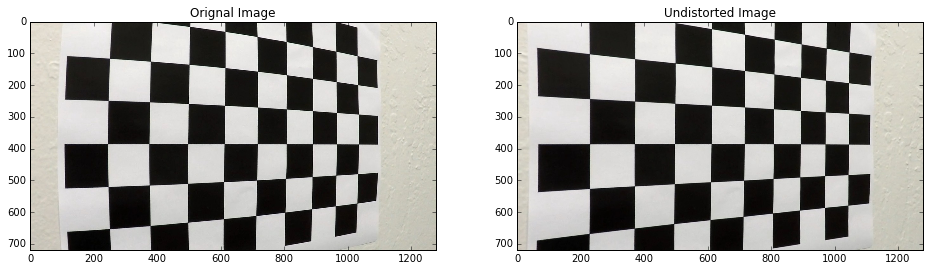

In [28]:

# undistort a test image
img = mpimg.imread('./camera_cal/test.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
u_img = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
ax1.imshow(img)
ax1.set_title('Orignal Image')
ax2.imshow(u_img)
ax2.set_title('Undistorted Image')

Now I have the ditortion matrix in `mtx` and distortion cofficients in `dist`.
I can use these to undistort the image frame from the video.

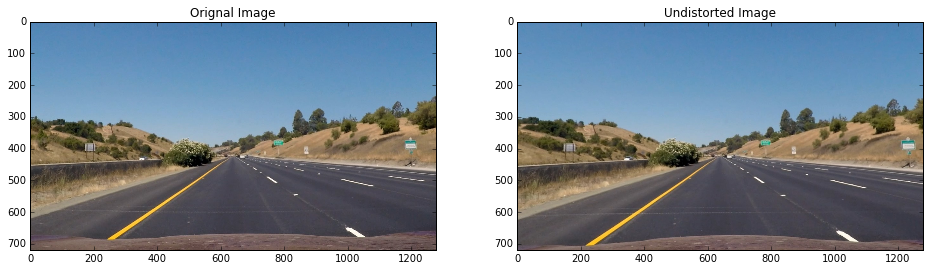

In [30]:
img = mpimg.imread('./test_images/straight_lines1.jpg')
u_img = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
ax1.imshow(img)
ax1.set_title('Orignal Image')
ax2.imshow(u_img)
ax2.set_title('Undistorted Image')
mpimg.imsave('straight_lines1_undistorted.jpg',u_img)

Now I need to change the perspective of the image so as to get a top down view of the road. This will show the lane lines parallel to each other.

For this I will create a source array `src` and a destination array `dst` and pass them to `cv2.getPerspectiveTransform()` to get the transformation matrix `M`

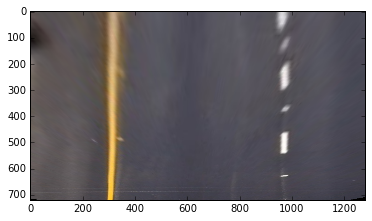

In [34]:
src = np.float32([[180,660], [580,450], [700,450], [1130,660]])
dst = np.float32([[200,719], [200,0], [1079,0], [1079,719]])
M = cv2.getPerspectiveTransform(src, dst)
img_size = (u_img.shape[1], u_img.shape[0])
warped = cv2.warpPerspective(u_img, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped)